# House Price Assignment

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

1. Which variables are significant in predicting the price of a house
2. How well those variables describe the price of a house.

Also, Determine the optimal value of lambda for ridge and lasso regression.


### We will take following step wise approach:
1. Exploratory Data Analytics
    - 1.1 Data Cleaning
    - 1.2 Outlier Treatment
    - 1.3 Univariate Analysis
    - 1.4 Multivariate Analysis
2. Data Preparation:
    - 2.1 Categorical: Create Dummy Variables
    - 2.2 Numeric: Rescaling
3. Model Builiding:
    - Model1: Multiple linear regression __without considering any multicollinearity__
    - Model2: Reduction of features with __RFE use top 20 features__
    - Model3: MLR with __Ridge regularization__ for all the variables
    - Model4: MLR with __Lasso regularization__ for all the variables
4. Model Analysis/Accuracy:
    - Final R2 Score on Training Data
    - Final R2 Score on Test Data
    - Verification of assumptions of Linear Regression
        - Residual Analysis
5. Model Comparison
___

# 1. Exploratory Data Analytics

#### Importing the Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

from scipy import stats 

import itertools
import warnings
warnings.filterwarnings('ignore')

#### Import Data

In [2]:
house_data = pd.read_csv('train.csv')
house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Observations:
* There seem to be many columns that have NaN values. We can get a snapshot of these and understand if we can remove such columns out of 81 columns
* There seem to be huge number of features in the dataset. Not all of them could be useful. We have to get rid of useless and redundant columns

___
## 1.2 Data Cleaning

### Checking for Outliers in Target Variable

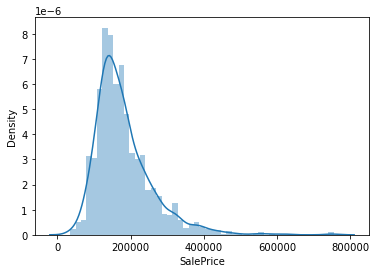

In [3]:
sns.distplot(house_data.SalePrice)
plt.show()

In [4]:
outlier_target = house_data.SalePrice.quantile([0,0.020, 0.025, 0.05, 0.1, 0.2, 0.25, 0.5, 0.7, 0.8, 0.9, 0.95, 0.975,0.99, 0.995,1])
outlier_target

0.000     34900.000
0.020     79000.000
0.025     80000.000
0.050     88000.000
0.100    106475.000
0.200    124000.000
0.250    129975.000
0.500    163000.000
0.700    198620.000
0.800    230000.000
0.900    278000.000
0.950    326100.000
0.975    384510.750
0.990    442567.010
0.995    527331.915
1.000    755000.000
Name: SalePrice, dtype: float64


#### Observations:
* Data is skewed towards right. Need to fix/delete outlier rows
* We can not delete these outlier values as these could be real prices hiked because multiple features avaialble in house
* We will examin the results of linear regression and decide if we need to/can transform the target variable


##### Checking for skewed ness

In [5]:
print("Skewness: %f" % house_data['SalePrice'].skew())
print("Kurtosis: %f" % house_data['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


#### Inference: Data is highly skewed and can be fixed with tranformation

___
### Missing Values

In [6]:
null_data_check = house_data.isnull().sum()
print("Number of columns in loan data: ",len(house_data.columns))
print("Number of columns that have null values: ",len(null_data_check[house_data.isnull().sum()!=0]))
print("Number of columns that have all null values: ", len(null_data_check[house_data.isnull().sum()==len(house_data)]))

Number of columns in loan data:  81
Number of columns that have null values:  19
Number of columns that have all null values:  0


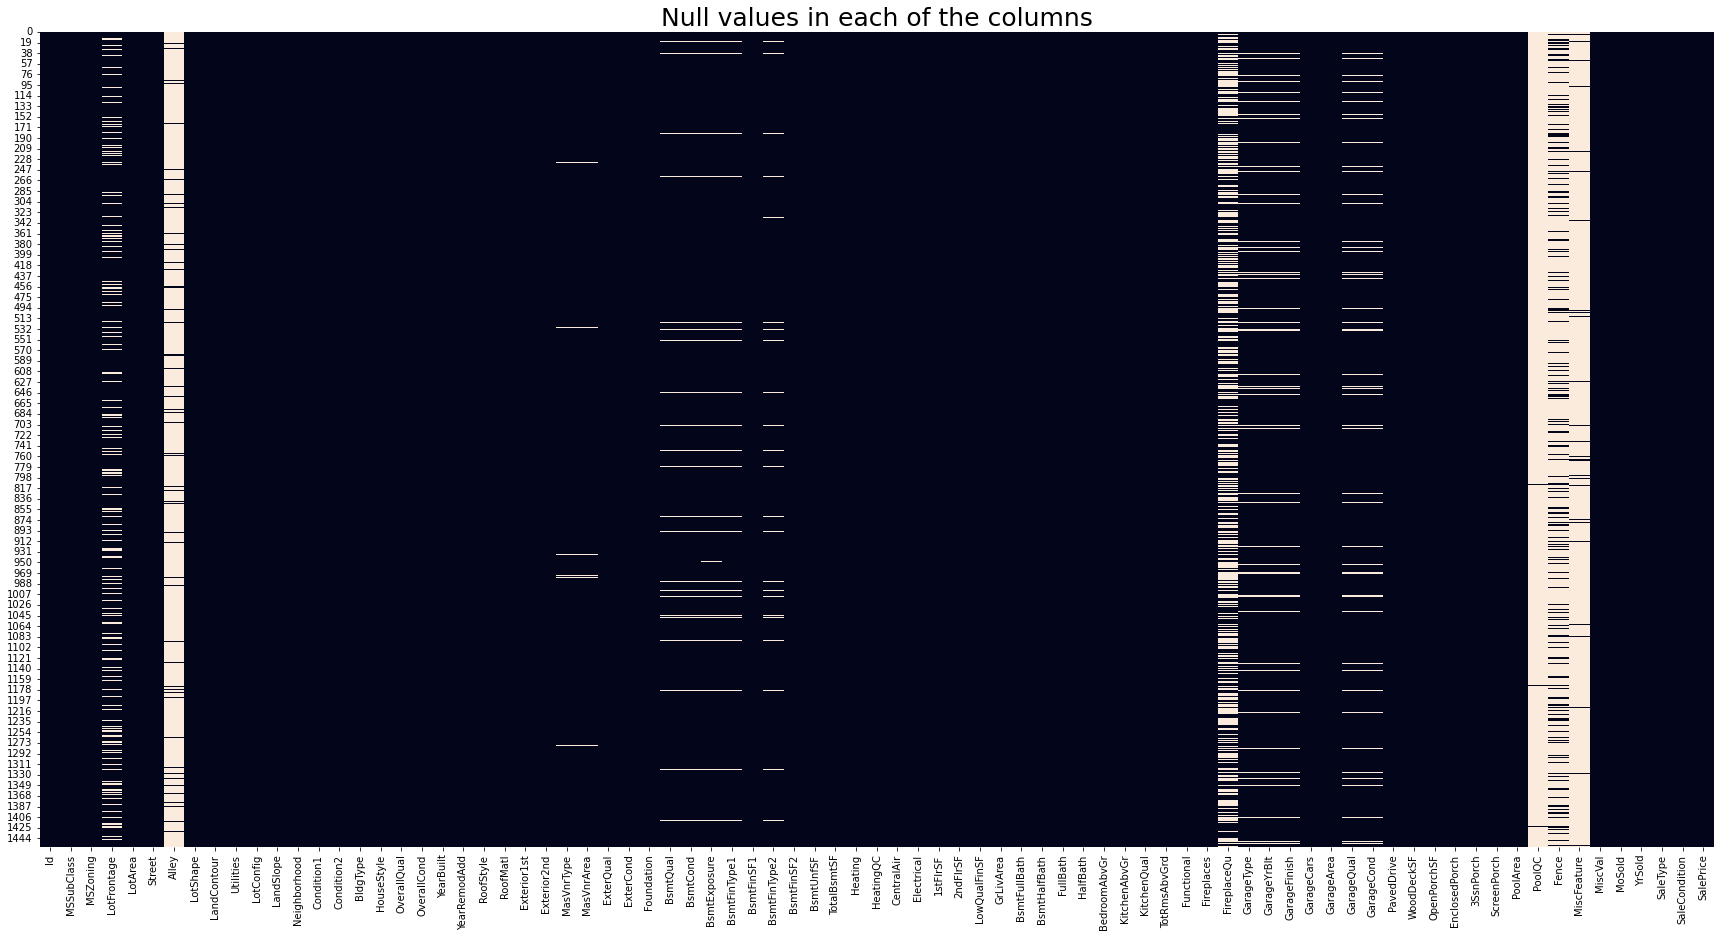

In [7]:
plt.figure(figsize=(30,15))
sns.heatmap(house_data.isnull(), cbar=False)
plt.title("Null values in each of the columns", fontdict={'fontsize':25})
plt.show()

In [8]:
total = house_data.isnull().sum().sort_values(ascending=False)
percent = ((house_data.isnull().sum()/house_data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


#### Observtaions:
* NAs in Features such as PoolQC, Fence mean non-availability of the feature; Which in majority cases as data presents will be the cases, is likely to fall under outlier category
* Also, Essentially these columns do not serve a purpose for regression model as they have very little to share
* Also, ID has no purpose when it comes to regression as it does not provide any other information

In [9]:
# print(house_data[~house_data['PoolQC'].isnull()]['SalePrice'])
# print(house_data['SalePrice'].mean())

##### Removing Columns that have majority missing values and non-useful columns such as ID

In [10]:
print("\n Dataframe Shape Before removing columns: ", house_data.shape)
house_data.drop(columns=['PoolQC','MiscFeature','Alley','Fence', 'Id'], inplace=True)
print("\n Dataframe Shape After removing the columns: ", house_data.shape)


 Dataframe Shape Before removing columns:  (1460, 81)

 Dataframe Shape After removing the columns:  (1460, 76)


##### Fixing the Missing Values for rest of the columns

In [11]:
missing_data.drop(['PoolQC','MiscFeature','Alley','Fence'], inplace=True)
md = missing_data[missing_data['Total']>0]

In [12]:
unique_df = pd.DataFrame(columns=['Column','Number of unique values','Unique Values'])
for i in md.index:
    unique_df.loc[len(unique_df)] = [i, house_data[i].nunique(), house_data[i].unique()]
unique_df

,Column,Number of unique values,Unique Values
0,FireplaceQu,5,"[nan, TA, Gd, Fa, Ex, Po]"
1,LotFrontage,110,"[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan..."
2,GarageYrBlt,97,"[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993...."
3,GarageCond,5,"[TA, Fa, nan, Gd, Po, Ex]"
4,GarageType,6,"[Attchd, Detchd, BuiltIn, CarPort, nan, Basmen..."
5,GarageFinish,3,"[RFn, Unf, Fin, nan]"
6,GarageQual,5,"[TA, Fa, Gd, nan, Ex, Po]"
7,BsmtFinType2,6,"[Unf, BLQ, nan, ALQ, Rec, LwQ, GLQ]"
8,BsmtExposure,4,"[No, Gd, Mn, Av, nan]"
9,BsmtQual,4,"[Gd, TA, Ex, nan, Fa]"


#### Let's replace categorical values with Mode and numeric values after an analysis
* Of the numeric variables, GarageYrBlt should be replaced with Median rest can be replaced with median as well since all of them have outliers(follw outlier analysis done later)

In [13]:
miss_cat = ['FireplaceQu','GarageCond','GarageType','GarageFinish', 'GarageQual','BsmtFinType2','BsmtExposure', 'BsmtQual', 'BsmtCond','BsmtFinType1','MasVnrType','Electrical']
miss_num = ['LotFrontage','GarageYrBlt','MasVnrArea']

for i in miss_cat:
    house_data[i].fillna("Not Available", inplace=True)
for j in miss_num:
    house_data[j].fillna(house_data[j].median(), inplace=True)

In [14]:
total = house_data.isnull().sum().sort_values(ascending=False)
percent = ((house_data.isnull().sum()/house_data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
MSSubClass,0,0.0
HalfBath,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0


#### Let us also examin the groups of columns to identify redundant columns if any 

In [15]:
#print(house_data.columns.tolist())

In [16]:
with pd.option_context('display.max_rows', None,):
    print(house_data.head().T)

                           0        1        2        3        4
MSSubClass                60       20       60       70       60
MSZoning                  RL       RL       RL       RL       RL
LotFrontage             65.0     80.0     68.0     60.0     84.0
LotArea                 8450     9600    11250     9550    14260
Street                  Pave     Pave     Pave     Pave     Pave
LotShape                 Reg      Reg      IR1      IR1      IR1
LandContour              Lvl      Lvl      Lvl      Lvl      Lvl
Utilities             AllPub   AllPub   AllPub   AllPub   AllPub
LotConfig             Inside      FR2   Inside   Corner      FR2
LandSlope                Gtl      Gtl      Gtl      Gtl      Gtl
Neighborhood         CollgCr  Veenker  CollgCr  Crawfor  NoRidge
Condition1              Norm    Feedr     Norm     Norm     Norm
Condition2              Norm     Norm     Norm     Norm     Norm
BldgType                1Fam     1Fam     1Fam     1Fam     1Fam
HouseStyle            2St

##### Changing MSSubClass to category as it is unordered categorical

In [17]:
house_data['MSSubClass'] = house_data['MSSubClass'].astype('str')

### Univariate Analysis

In [18]:
numeric = house_data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
numeric.remove('SalePrice')
print(numeric)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


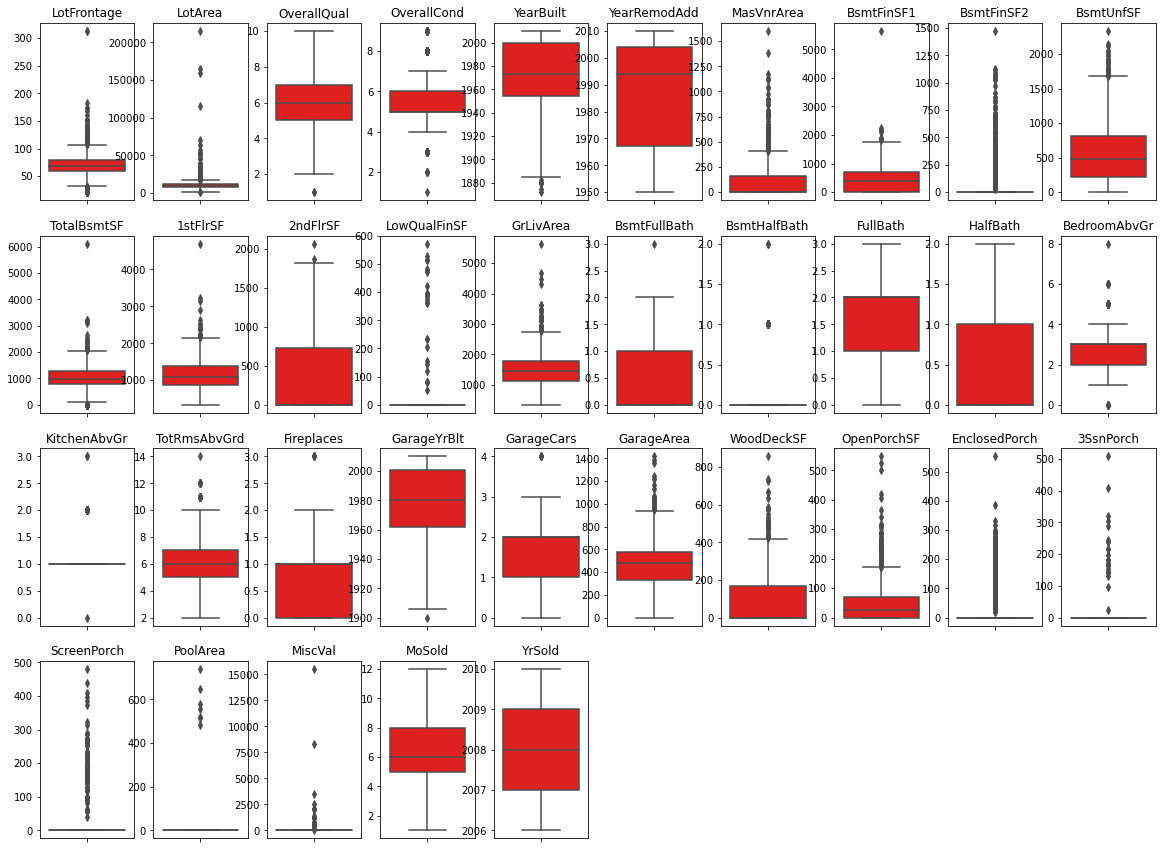

In [19]:
plt.figure(figsize=[20,15])
for i,j in itertools.zip_longest(numeric, range(len(numeric))):
    plt.subplot(4,10,j+1)
    ax = sns.boxplot(y = house_data[i], color='red')
    ax.set(ylabel=None)
    plt.title(i)

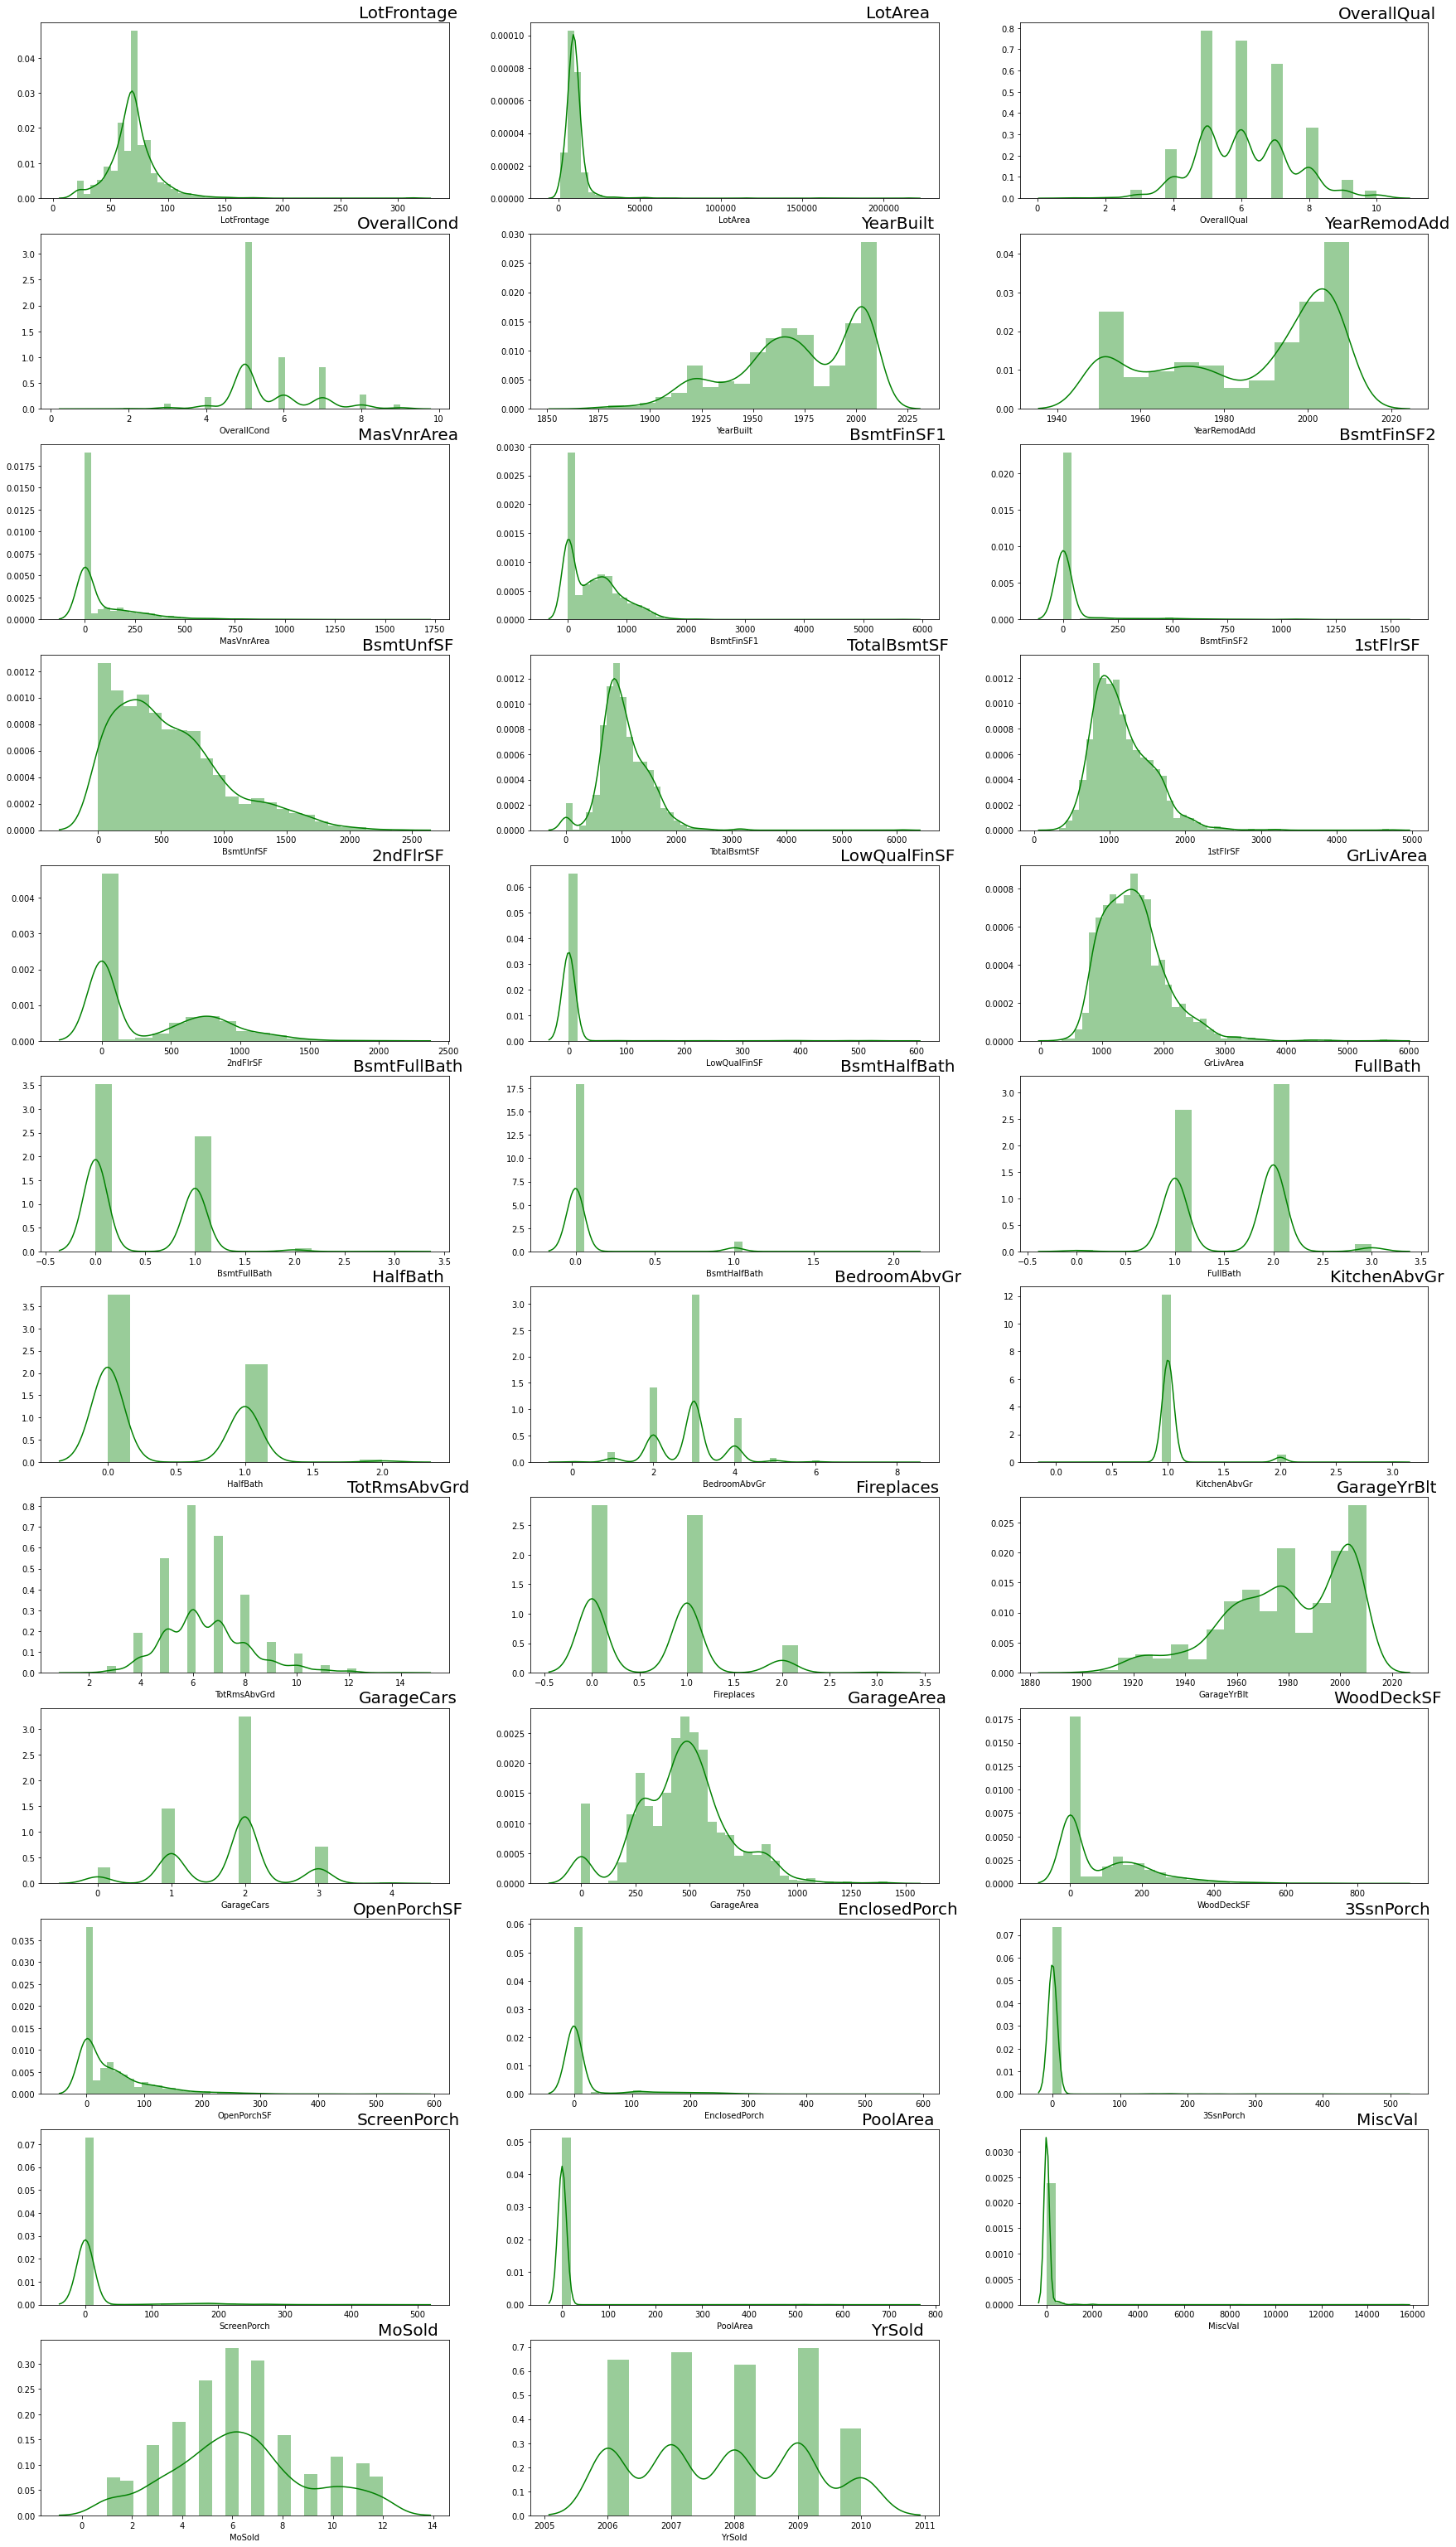

In [20]:
plt.figure(figsize=[30,60])
for i,j in itertools.zip_longest(numeric, range(len(numeric))):
    plt.subplot(13,3,j+1)
    ax = sns.distplot(house_data[i], color='green')
    ax.set(ylabel=None)
    ax.title.set_position([0.9, 1])
    plt.title(i,fontdict={'fontsize':20})

#### Observations: 
* There are few features that might need transformation because they have outliers as well as non normal distribution
* Many of the features have spike/max value as 0; We must impute/delete all columns that have such values

* Overall, we need to transform both target variable and a few features that have high skew 

### Transforming the Variables

In [21]:
# Check for the skewed variables
transform_needed = []
for i in numeric:
    if ((house_data[i].skew() >1.0)):
        transform_needed.append(i)
        #print(house_data[i].kurt())
print(transform_needed)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [22]:
# transform_neg = []
# for i in numeric:
#     if ((house_data[i].skew() < -0.6)):
#         transform_neg.append(i)
#         #print(house_data[i].kurt())
# print(transform_neg)

In [23]:
skew_values = pd.DataFrame(columns=['Cols','Values'])
for i in numeric:
    if ((house_data[i].skew() > 1.0) | (house_data[i].skew() < -0.6)):
        skew_values.loc[len(skew_values)]  = [i,house_data[i].skew()]
skew_values.sort_values(['Values'], ascending=False)

,Cols,Values
19,MiscVal,24.476794
18,PoolArea,14.828374
1,LotArea,12.207688
16,3SsnPorch,10.304342
8,LowQualFinSF,9.011341
11,KitchenAbvGr,4.488397
5,BsmtFinSF2,4.255261
17,ScreenPorch,4.122214
10,BsmtHalfBath,4.103403
15,EnclosedPorch,3.089872


##### Transformation

In [24]:
# Since most of these variables have 0s in them, we will use log(n+1) as log of 0 is not defined

house_data[transform_needed] = np.log1p(house_data[transform_needed])

#house_data[transform_neg] = np.square(house_data[transform_neg])

# Let us use log transformation on target variable as well

house_data['SalePrice'] = np.log(house_data['SalePrice'])

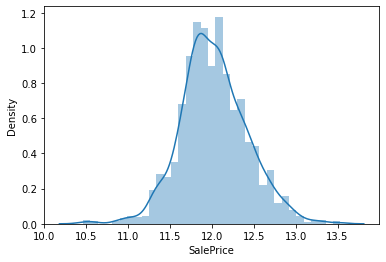

In [25]:
sns.distplot(house_data.SalePrice)
plt.show()

In [26]:
house_data['SalePrice'].skew()

0.12133506220520406

#### The Target variable now shows normal curve 

### Features' Relation with SalePrice

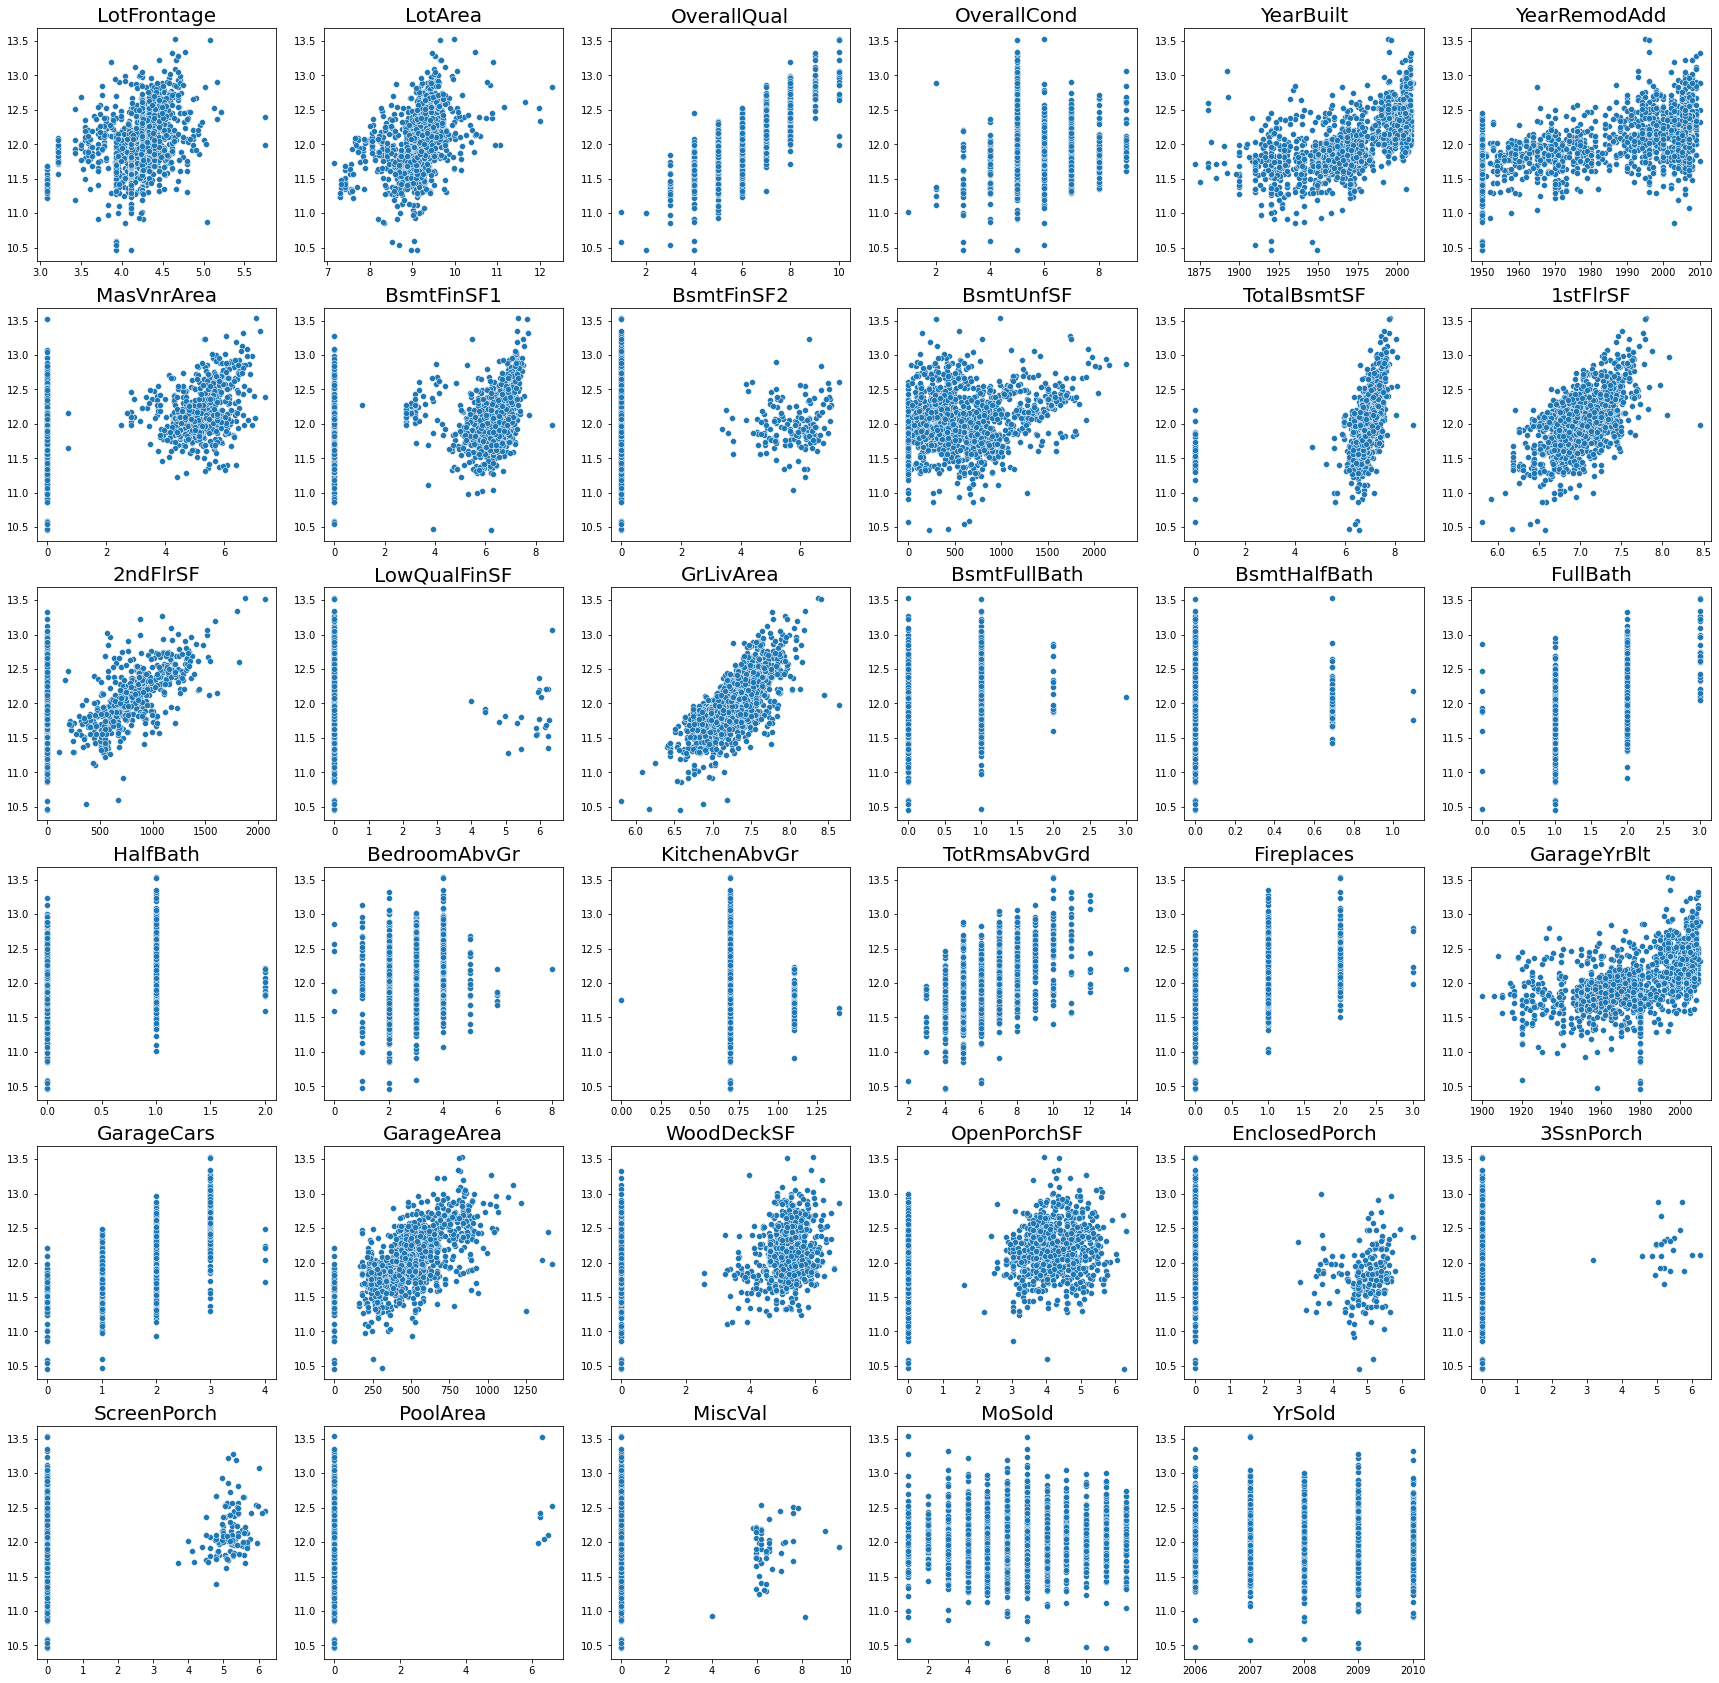

In [27]:
plt.figure(figsize=[30,30])
for i,j in itertools.zip_longest(numeric, range(len(numeric))):
    plt.subplot(6,6,j+1)
    ax = sns.scatterplot(data = house_data, x= i, y = 'SalePrice')
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    plt.title(i, fontdict={'fontsize':20})

#### Observations:
* Areas of OverllQuality, GarageCars, 1st floor, 2nd floor, basement, GrLivingArea have high correlation with target variable

#### Cross Feature Correlation

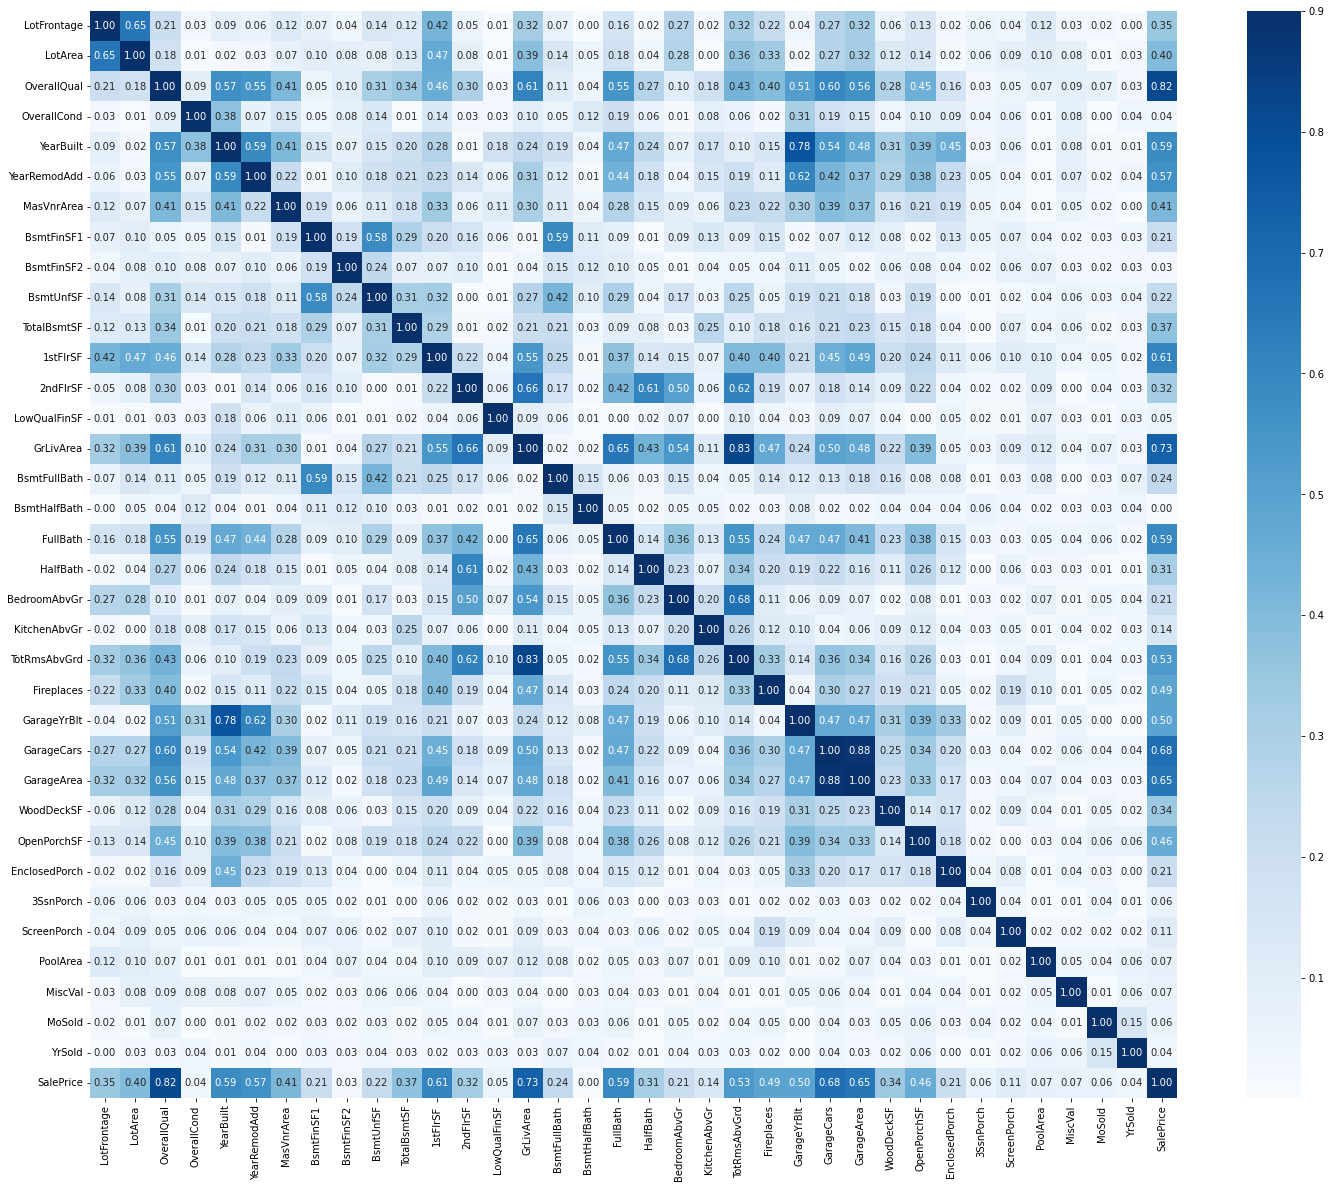

In [28]:
corr = house_data.corr()
plt.figure(figsize=(25,20))
sns.heatmap(corr.abs(), vmax=0.9, cmap="Blues", square=True, annot=True, fmt='0.2f')
plt.show()

##### There are few features that are highly correlated and present more or less the similar information:
* Garage Cars and garage Area have high correlation (0.88)
* Garage Built Year with Year built (0.78), primariliy because most of the houses have garage built the same time when house is built
* Total rooms above groud with Above ground living area(0.83); which again is intuitive
* Total basement surface area with 1st floor area(0.82) which makes sense again because one usually uses whole of the area over basement;

__We can remove each of these columns manually, based on what features explain saleprice the least__

In [29]:
print("\n Dataframe Shape Before removing columns: ", house_data.shape)
house_data.drop(['GarageArea','GarageYrBlt','TotRmsAbvGrd','TotalBsmtSF'], axis=1, inplace=True)
print("\n Dataframe Shape After removing the columns: ", house_data.shape)


 Dataframe Shape Before removing columns:  (1460, 76)

 Dataframe Shape After removing the columns:  (1460, 72)


In [30]:
house_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal,12.247694
1,20,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal,12.109011
2,60,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal,12.317167
3,70,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,5.609472,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,11.849398
4,60,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal,12.429216


### Get dummies

In [31]:
dummy_cols = house_data.select_dtypes(include='object').columns
len(dummy_cols)

40

In [32]:
house_w_dummies = house_data.copy()
house_w_dummies = pd.get_dummies(house_w_dummies[dummy_cols],drop_first=True).reset_index(drop=True)
house_w_dummies.shape

(1460, 226)

In [33]:
new_house_data = pd.concat([house_data, house_w_dummies], axis=1)
new_house_data.drop(columns=dummy_cols, inplace=True)

### Split data for feature and target

In [34]:
house_train,house_test = train_test_split(new_house_data, train_size= 0.7, random_state=100)

In [35]:
y_train = house_train['SalePrice']
X_train = house_train.drop(columns={'SalePrice'})
y_test = house_test['SalePrice']
X_test = house_test.drop(columns={'SalePrice'})

#### Feature Rescaling

In [36]:
scaler = MinMaxScaler()
X_train_1 = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_1, columns = X_train.columns)

X_test_1 = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_1, columns = X_test.columns)

In [37]:
X_train.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,...,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000
mean,0.420472,0.362921,0.565894,0.572600,0.719719,0.583072,0.287677,0.493021,0.092315,0.241329,...,0.002938,0.003918,0.078355,0.002938,0.870715,0.002938,0.007835,0.013712,0.825661,0.078355
std,0.120316,0.104329,0.155515,0.136515,0.219718,0.343416,0.356328,0.344776,0.257264,0.192097,...,0.054153,0.062500,0.268860,0.054153,0.335680,0.054153,0.088214,0.116350,0.379587,0.268860
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.383633,0.324733,0.444444,0.500000,0.594203,0.283333,0.000000,0.000000,0.000000,0.092466,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.435403,0.373660,0.555556,0.500000,0.731884,0.733333,0.000000,0.691531,0.000000,0.197774,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.480902,0.412116,0.666667,0.625000,0.927536,0.900000,0.686994,0.760486,0.000000,0.345034,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
X_test.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,439.000000,439.000000,439.000000,439.00000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,...,439.000000,439.000000,439.000000,439.0,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000
mean,0.427537,0.366112,0.568211,0.57033,0.718431,0.576500,0.286628,0.481762,0.084033,0.246305,...,0.004556,0.002278,0.095672,0.0,0.861048,0.002278,0.009112,0.013667,0.808656,0.102506
std,0.113338,0.102868,0.149440,0.14508,0.217104,0.346002,0.356568,0.350290,0.242532,0.182297,...,0.067420,0.047727,0.294476,0.0,0.346291,0.047727,0.095127,0.116239,0.393808,0.303658
min,0.000000,-0.025608,0.000000,0.12500,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.383633,0.332399,0.444444,0.50000,0.594203,0.266667,0.000000,0.000000,0.000000,0.109161,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.435403,0.370895,0.555556,0.50000,0.724638,0.716667,0.000000,0.682020,0.000000,0.214041,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.490307,0.415368,0.666667,0.62500,0.934783,0.900000,0.699989,0.759585,0.000000,0.346318,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,0.939196,1.000000,1.00000,0.992754,1.000000,0.925209,0.890337,0.963241,0.828339,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### General Regression Test

In [39]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [40]:
y_pred = reg.predict(X_train)

In [41]:
r2_score(y_train,y_pred)

0.9599833609455413

#### This would mean, that the features explain ~94% of variations in target variable
___

#### Test for variables that have most linear relationship

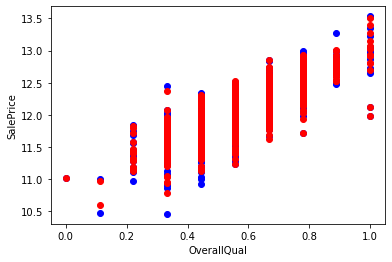

In [42]:
plt.scatter(X_train['OverallQual'], y_train, color='blue')
plt.scatter(X_train['OverallQual'], y_pred, color = 'red')
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")
plt.show()

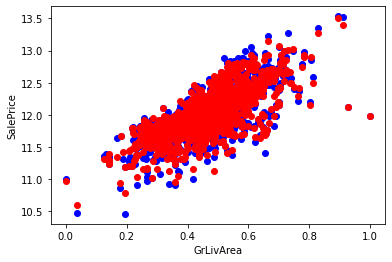

In [43]:
plt.scatter(X_train['GrLivArea'], y_train, color='blue')
plt.scatter(X_train['GrLivArea'], y_pred, color = 'red')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [44]:
print(reg.intercept_)
#print(reg.coef_)

7.717592251270563


In [45]:
rss_norm_train = np.sum(np.square(y_train-y_pred))
print(rss_norm_train)
mse_norm_train = mean_squared_error(y_train,y_pred)
print(mse_norm_train)
rmse_norm_train = np.sqrt(mse_norm_train)
print(rmse_norm_train)
r2_norm_train = r2_score(y_train,y_pred)
print(r2_norm_train)

6.42044552745603
0.006288389351083281
0.07929936538890636
0.9599833609455413


In [46]:
y_res = y_train - y_pred

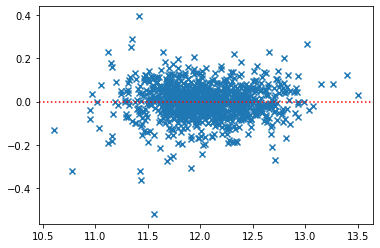

In [47]:
plt.scatter(y_pred,y_res, marker='x')
plt.axhline(y=0,color ='r', linestyle =':')
plt.show()

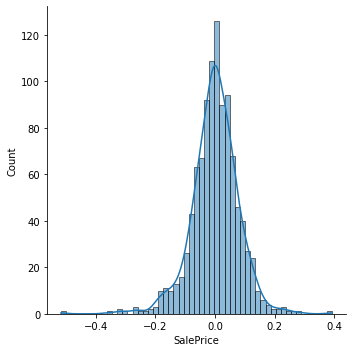

In [48]:
sns.displot(y_res,kde=True)
plt.show()

In [49]:
y_test_pred = reg.predict(X_test)

In [50]:
r2_score(y_test,y_test_pred)

-2.974575476222397e+21

In [51]:
rss_norm_test = np.sum(np.square(y_test-y_test_pred))
print(rss_norm_test)
mse_norm_test = mean_squared_error(y_test,y_test_pred)
print(mse_norm_test)
rmse_norm_test = np.sqrt(mse_norm_test)
print(rmse_norm_test)
r2_norm_test = r2_score(y_test,y_test_pred)
print(r2_norm_test)

2.1522150163805752e+23
4.902539900639123e+20
22141679928.675518
-2.974575476222397e+21


In [52]:
y_res1 = y_test- y_test_pred

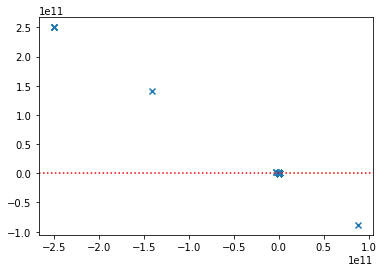

In [53]:
plt.scatter(y_test_pred,y_res1, marker='x')
plt.axhline(y=0,color ='r', linestyle =':')
plt.show()

#### This is clearly a case of Overfitting. We would need to use regularization techniques to handel this.

## RFE Method

In [54]:
lm= LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,20)
rfe = rfe.fit(X_train,y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))
rfe_df = pd.DataFrame({'Predictor': X_train.columns, 'Select Status': rfe.support_, 'Ranking': rfe.ranking_})
rfe_df.sort_values(by = 'Ranking', inplace=True)

In [55]:
top = X_train.columns[rfe.support_]
top

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'MSZoning_FV', 'MSZoning_RH',
       'Condition2_PosN', 'RoofMatl_CompShg', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_BrkComm',
       'Functional_Sev'],
      dtype='object')

In [56]:
X_train_rfe = X_train[top]
X_test_rfe = X_test[top]

In [57]:
lm1 = lm.fit(X_train_rfe,y_train)
print(lm1.intercept_)
print(lm1.coef_)

8.290624570345251
[ 0.60610541  0.83724911  0.47934652  0.59389825  0.95049456  0.35253833
  0.58705531 -0.34119664  0.06656097  0.02297373 -1.42040738  1.71896513
  1.77284977  1.85222266  1.66962901  1.83177539  1.55698202  1.81279278
 -0.40472856 -0.69775822]


In [58]:
y_pred_rfe_train = lm1.predict(X_train_rfe)
y_pred_rfe_test = lm1.predict(X_test_rfe)

In [59]:
rfe_cols = pd.DataFrame(index=X_test_rfe.columns)

rfe_cols.rows = X_test.columns

rfe_cols['Coef_Values'] = lm1.coef_

rfe_best_cols = rfe_cols[~(rfe_cols['Coef_Values']==0)]
rfe_best_cols.sort_values(by = 'Coef_Values', ascending=False ,inplace=True)
rfe_best_cols.head(10)

,Coef_Values
RoofMatl_Metal,1.852223
RoofMatl_Tar&Grv,1.831775
RoofMatl_WdShngl,1.812793
RoofMatl_Membran,1.772850
RoofMatl_CompShg,1.718965
RoofMatl_Roll,1.669629
RoofMatl_WdShake,1.556982
1stFlrSF,0.950495
OverallQual,0.837249
LotArea,0.606105


In [60]:
rss_rfe_train = np.sum(np.square(y_train-y_pred_rfe_train))
print(rss_rfe_train)
mse_rfe_train = mean_squared_error(y_train,y_pred_rfe_train)
print(mse_rfe_train)
rmse_rfe_train = np.sqrt(mse_rfe_train)
print(rmse_rfe_train)
r2_rfe_train = r2_score(y_train,y_pred_rfe_train)
print(r2_rfe_train)

17.48152196828461
0.017121960791659757
0.1308509105496013
0.8910431134824037


In [61]:
rss_rfe_test = np.sum(np.square(y_test-y_pred_rfe_test))
print(rss_rfe_test)
mse_rfe_test = mean_squared_error(y_test,y_pred_rfe_test)
print(mse_rfe_test)
rmse_rfe_test = np.sqrt(mse_rfe_test)
print(rmse_rfe_test)
r2_rfe_test = r2_score(y_test,y_pred_rfe_test)
print(r2_rfe_test)

11.840525618934542
0.026971584553381646
0.16423027903946838
0.8363521448200988


In [62]:
y_res2 = y_test-y_pred_rfe_test

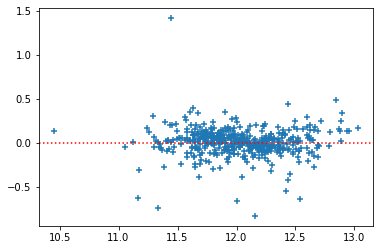

In [63]:
plt.scatter(y_pred_rfe_test,y_res2, marker='+')
plt.axhline(y=0,color ='r', linestyle =':')
plt.show()

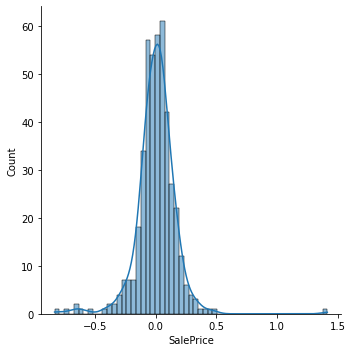

In [64]:
sns.displot(y_res2,kde=True)
plt.show()

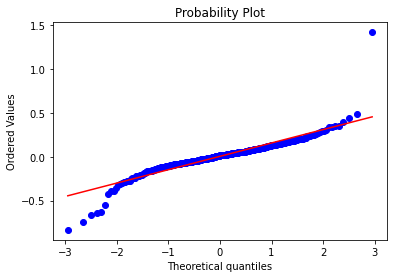

In [65]:
fig = plt.figure()
res = stats.probplot(y_res2, plot=plt)

## Ridge Rigression

In [66]:
var = [0,.001,0.01,0.1,0.5,1,2,3,5,10,100,1000]
params = {'alpha':var}

ridge = Ridge()

f = 5

ridge_model = GridSearchCV(estimator=ridge, param_grid=params, scoring='neg_mean_absolute_error',
                          cv =f , return_train_score=True, verbose=True)

ridge_model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 0.001, 0.01, 0.1, 0.5, 1, 2, 3, 5, 10,
                                   100, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=True)

In [67]:
print(ridge_model.best_params_)
#print(ridge_model.best_score_)

{'alpha': 1}


In [68]:
a = ridge_model.best_params_['alpha']
ridge_best = Ridge(alpha=a)
ridge_best.fit(X_train, y_train)
ridge_best.intercept_

9.998438434579324

In [69]:
y_pred_ridge_train = ridge_best.predict(X_train)
y_pred_ridge_test = ridge_best.predict(X_test)

In [70]:
r2_train_ridge = r2_score(y_train, y_pred_ridge_train)
r2_test_ridge = r2_score(y_test, y_pred_ridge_test)

print("r2 for train with Ridge:", r2_train_ridge)
print("r2 for test with Ridge:", r2_test_ridge)

r2 for train with Ridge: 0.9465520559603354
r2 for test with Ridge: 0.89130710716017


In [71]:
rss_ridge_train = np.sum(np.square(y_train-y_pred_ridge_train))
print(rss_ridge_train)
mse_ridge_train = mean_squared_error(y_train,y_pred_ridge_train)
print(mse_ridge_train)
rmse_ridge_train = np.sqrt(mse_ridge_train)
print(rmse_ridge_train)
r2_ridge_train = r2_score(y_train,y_pred_ridge_train)
print(r2_ridge_train)

8.57542315820622
0.008399043249957121
0.09164629425108863
0.9465520559603354


In [72]:
rss_ridge_test = np.sum(np.square(y_test-y_pred_ridge_test))
print(rss_ridge_test)
mse_ridge_test = mean_squared_error(y_test,y_pred_ridge_test)
print(mse_ridge_test)
rmse_ridge_test = np.sqrt(mse_ridge_test)
print(rmse_ridge_test)
r2_ridge_test = r2_score(y_test,y_pred_ridge_test)
print(r2_ridge_test)

7.864331499189592
0.017914194758974013
0.13384391939484594
0.89130710716017


In [73]:
y_res3 = y_test-y_pred_ridge_test

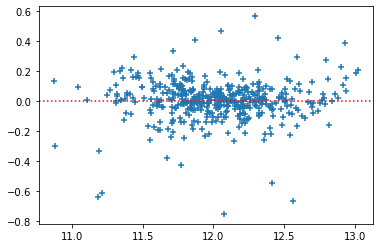

In [74]:
plt.scatter(y_pred_ridge_test,y_res3, marker='+')
plt.axhline(y=0,color ='r', linestyle =':')
plt.show()

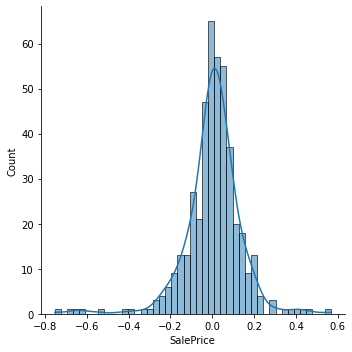

In [75]:
sns.displot(y_res3,kde=True)
plt.show()

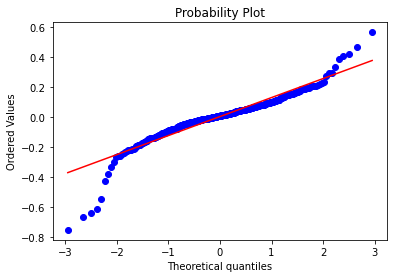

In [76]:
fig = plt.figure()
res = stats.probplot(y_res3, plot=plt)

In [77]:
ridge_cols = pd.DataFrame(index=X_test.columns)

ridge_cols.rows = X_test.columns

ridge_cols['Ridge_values'] = ridge_best.coef_

ridge_best_cols = ridge_cols[~(ridge_cols['Ridge_values']==0)]
ridge_best_cols.sort_values(by = 'Ridge_values', ascending=False ,inplace=True)
ridge_best_cols.head(10)

,Ridge_values
GrLivArea,0.490089
1stFlrSF,0.380617
OverallQual,0.323280
LotArea,0.293868
2ndFlrSF,0.259367
RoofMatl_WdShngl,0.237631
OverallCond,0.232162
MSZoning_RL,0.218558
MSZoning_FV,0.217904
MSZoning_RH,0.216595


___

## Lasso Regression

In [78]:
var = [0,.001,0.01,0.1,0.5,1,2,3,5,10,100,1000]
params = {'alpha':var}

lasso = Lasso()
f = 5

lasso_model = GridSearchCV(estimator=lasso, param_grid=params, scoring='neg_mean_absolute_error',
                          cv =f , return_train_score=True, verbose=True)

lasso_model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 0.001, 0.01, 0.1, 0.5, 1, 2, 3, 5, 10,
                                   100, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=True)

In [79]:
print(lasso_model.best_params_)
#print(lasso_model.best_score_)

{'alpha': 0.001}


In [80]:
al = lasso_model.best_params_['alpha']
lasso_best = Lasso(alpha=al)
lasso_best.fit(X_train, y_train)
lasso_best.intercept_

10.506578870676096

In [81]:
y_pred_lasso_train = lasso_best.predict(X_train)
y_pred_lasso_test = lasso_best.predict(X_test)

In [82]:
r2_train_lasso = r2_score(y_train, y_pred_lasso_train)
r2_test_lasso = r2_score(y_test, y_pred_lasso_test)

print("r2 for train with Ridge:", r2_train_lasso)
print("r2 for test with Ridge:", r2_test_lasso)

r2 for train with Ridge: 0.9165276586750833
r2 for test with Ridge: 0.8910688661778003


In [83]:
rss_lasso_train = np.sum(np.square(y_train-y_pred_lasso_train))
print(rss_lasso_train)
mse_lasso_train = mean_squared_error(y_train,y_pred_lasso_train)
print(mse_lasso_train)
rmse_lasso_train = np.sqrt(mse_lasso_train)
print(rmse_lasso_train)
r2_lasso_train = r2_score(y_train,y_pred_lasso_train)
print(r2_lasso_train)

13.39266947922581
0.01311720810893811
0.11453038072467109
0.9165276586750833


In [84]:
rss_lasso_test = np.sum(np.square(y_test-y_pred_lasso_test))
print(rss_lasso_test)
mse_lasso_test = mean_squared_error(y_test,y_pred_lasso_test)
print(mse_lasso_test)
rmse_lasso_test = np.sqrt(mse_lasso_test)
print(rmse_lasso_test)
r2_lasso_test = r2_score(y_test,y_pred_lasso_test)
print(r2_lasso_test)

7.8815691125523015
0.017953460393057636
0.1339905235196043
0.8910688661778003


In [85]:
y_res4 = y_test-y_pred_lasso_test

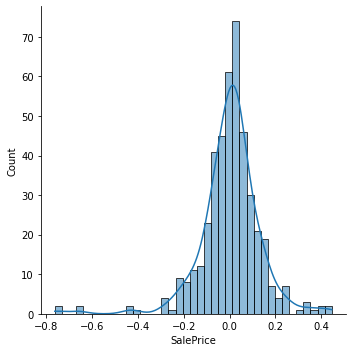

In [86]:
sns.displot(y_res4,kde=True)
plt.show()

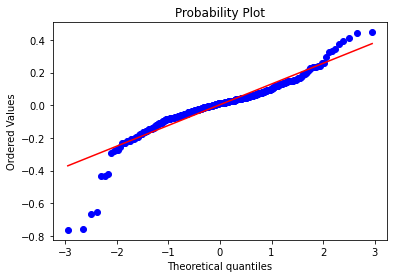

In [87]:
fig =plt.figure()
res = stats.probplot(y_res4, plot=plt)

In [88]:
lasso_1 = pd.DataFrame(index=X_test.columns)

lasso_1.rows = X_test.columns

lasso_1['Lasso_values'] = lasso_best.coef_

lasso_2 = lasso_1[~(lasso_1['Lasso_values']==0)]
lasso_2.sort_values(by = 'Lasso_values', ascending=False ,inplace=True)
lasso_2.head(10)

,Lasso_values
GrLivArea,1.004206
OverallQual,0.485015
OverallCond,0.224901
GarageCars,0.199269
LotArea,0.195753
YearBuilt,0.113421
1stFlrSF,0.102108
Neighborhood_Somerst,0.101365
BsmtFinSF1,0.098480
Neighborhood_Crawfor,0.093776


___

## Scores

In [89]:
Scores = {'Model_Name': ['Linear Regression', 'Linear_with_RFE','Ridge','Lasso'],
                  'Training R2 Score':[r2_norm_train,r2_rfe_train,r2_ridge_train,r2_lasso_train],
                  'Testing R2 SCore':[r2_norm_test,r2_rfe_test,r2_ridge_test,r2_lasso_test],
                  'Training RMSE':[rmse_norm_train,rmse_rfe_train,rmse_ridge_train,rmse_lasso_train],
                  'Testing RMSE ':[rmse_norm_test,rmse_rfe_test,rmse_ridge_test,rmse_lasso_test]
}
Score_df = pd.DataFrame(Scores)
Score_df

,Model_Name,Training R2 Score,Testing R2 SCore,Training RMSE,Testing RMSE
0,Linear Regression,0.959983,-2.974575e+21,0.079299,2.214168e+10
1,Linear_with_RFE,0.891043,8.363521e-01,0.130851,1.642303e-01
2,Ridge,0.946552,8.913071e-01,0.091646,1.338439e-01
3,Lasso,0.916528,8.910689e-01,0.114530,1.339905e-01


___
## Conclusion:

* Since normal regreassion model has negetive r2 score, __Normal Regression is worst model__
* Ridge and Lasso both have good performance, however, Lasso has more similar training and test r2 scores, we can say __Lasso has performed better of all the mdoels__


* Best alpha value for Ridge: __1__
* Best alpha value for Lasso: __0.001__

* Best Variables to describe according to best algorithm Lasso hence are (along with the impact):

GrLivArea	1.004206,  OverallQual	0.485015,
OverallCond	0.224901,  GarageCars	0.199269,
LotArea	0.195753, YearBuilt	0.113421, 
1stFlrSF	0.102108, Neighborhood_Somerst	0.101365,
BsmtFinSF1	0.098480, Neighborhood_Crawfor	(0.093776)



* There is a loose tail/ left skew in residuals normal curve. This is primarily because of the '0' values in most of the features that translate into Not Available

___

# PART II Assignments Calculations

___Q1. What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?___
___

#### Ridge doubling the alpha

In [90]:
a = ridge_model.best_params_['alpha'] * 2
ridge_best = Ridge(alpha=a)
ridge_best.fit(X_train, y_train)
ridge_best.intercept_

10.261132108989681

In [91]:
y_pred_ridge_train = ridge_best.predict(X_train)
y_pred_ridge_test = ridge_best.predict(X_test)

In [92]:
r2_train_ridge = r2_score(y_train, y_pred_ridge_train)
r2_test_ridge = r2_score(y_test, y_pred_ridge_test)

print("r2 for train with Ridge:", r2_train_ridge)
print("r2 for test with Ridge:", r2_test_ridge)

r2 for train with Ridge: 0.9416282806339984
r2 for test with Ridge: 0.8917123481130442


In [93]:
rss_ridge_train = np.sum(np.square(y_train-y_pred_ridge_train))
print(rss_ridge_train)
mse_ridge_train = mean_squared_error(y_train,y_pred_ridge_train)
print(mse_ridge_train)
rmse_ridge_train = np.sqrt(mse_ridge_train)
print(rmse_ridge_train)
r2_ridge_train = r2_score(y_train,y_pred_ridge_train)
print(r2_ridge_train)

9.365415321944848
0.009172786799162436
0.09577466679222871
0.9416282806339984


In [94]:
ridge_cols = pd.DataFrame(index=X_test.columns)

ridge_cols.rows = X_test.columns

ridge_cols['Ridge_values'] = ridge_best.coef_

ridge_best_cols = ridge_cols[~(ridge_cols['Ridge_values']==0)]
ridge_best_cols.sort_values(by = 'Ridge_values', ascending=False ,inplace=True)
ridge_best_cols.head(10)

,Ridge_values
GrLivArea,0.424510
1stFlrSF,0.353403
OverallQual,0.309259
LotArea,0.238279
2ndFlrSF,0.231247
OverallCond,0.210780
GarageCars,0.181081
BsmtFinSF1,0.174922
RoofMatl_WdShngl,0.163805
MSZoning_RL,0.156659


#### Lasso Doubling alpha values

In [95]:
al = lasso_model.best_params_['alpha'] *2
lasso_best = Lasso(alpha=al)
lasso_best.fit(X_train, y_train)
lasso_best.intercept_

10.656782914465744

In [96]:
y_pred_lasso_train = lasso_best.predict(X_train)
y_pred_lasso_test = lasso_best.predict(X_test)

In [97]:
r2_train_lasso = r2_score(y_train, y_pred_lasso_train)
r2_test_lasso = r2_score(y_test, y_pred_lasso_test)

print("r2 for train with Ridge:", r2_train_lasso)
print("r2 for test with Ridge:", r2_test_lasso)

r2 for train with Ridge: 0.8994000793621877
r2 for test with Ridge: 0.8769866693669235


In [98]:
rss_lasso_train = np.sum(np.square(y_train-y_pred_lasso_train))
print(rss_lasso_train)
mse_lasso_train = mean_squared_error(y_train,y_pred_lasso_train)
print(mse_lasso_train)
rmse_lasso_train = np.sqrt(mse_lasso_train)
print(rmse_lasso_train)
r2_lasso_train = r2_score(y_train,y_pred_lasso_train)
print(r2_lasso_train)

16.14069361603488
0.015808710691513104
0.12573269539587983
0.8994000793621877


In [99]:
rss_lasso_test = np.sum(np.square(y_test-y_pred_lasso_test))
print(rss_lasso_test)
mse_lasso_test = mean_squared_error(y_test,y_pred_lasso_test)
print(mse_lasso_test)
rmse_lasso_test = np.sqrt(mse_lasso_test)
print(rmse_lasso_test)
r2_lasso_test = r2_score(y_test,y_pred_lasso_test)
print(r2_lasso_test)

8.900467966599397
0.02027441450250432
0.14238825268435706
0.8769866693669235


In [100]:
lasso_1 = pd.DataFrame(index=X_test.columns)

lasso_1.rows = X_test.columns

lasso_1['Lasso_values'] = lasso_best.coef_

lasso_2 = lasso_1[~(lasso_1['Lasso_values']==0)]
lasso_2.sort_values(by = 'Lasso_values', ascending=False ,inplace=True)
lasso_2.head(10)

,Lasso_values
GrLivArea,0.965295
OverallQual,0.539929
GarageCars,0.208591
LotArea,0.126117
OverallCond,0.124212
BsmtFinSF1,0.106562
YearRemodAdd,0.099791
CentralAir_Y,0.071542
Neighborhood_Somerst,0.071002
Neighborhood_NridgHt,0.068330


### Answer:

* Ridge: Most of the scores inclusing R2 remains similar/comparable even after doubling the alpha 
* Lasso: Both R2 for train and test dropped by ~2% after doubling the alpha


* 'GrLivArea' remains the top most feature even after changing both alphas
* Order and coef values of important features changed in Lasso on doubling action while order remained same for Ridge (coef values changed)

___

___Q3. After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?___
___

In [101]:
X_train_sub = X_train.drop(columns=['GrLivArea','OverallQual','OverallCond','GarageCars', 'LotArea'])
X_test_sub = X_test.drop(columns=['GrLivArea','OverallQual','OverallCond','GarageCars', 'LotArea'])

In [102]:
al = lasso_model.best_params_['alpha']
lasso_best = Lasso(alpha=al)
lasso_best.fit(X_train_sub, y_train)
lasso_best.intercept_

11.049400694092315

In [103]:
y_pred_lasso_train = lasso_best.predict(X_train_sub)
y_pred_lasso_test = lasso_best.predict(X_test_sub)

In [104]:
r2_train_lasso = r2_score(y_train, y_pred_lasso_train)
r2_test_lasso = r2_score(y_test, y_pred_lasso_test)

print("r2 for train with Lasso:", r2_train_lasso)
print("r2 for test with Lasso:", r2_test_lasso)

r2 for train with Lasso: 0.9014816640996798
r2 for test with Lasso: 0.8629246413658136


In [105]:
lasso_1 = pd.DataFrame(index=X_test_sub.columns)

lasso_1.rows = X_test_sub.columns

lasso_1['Lasso_values'] = lasso_best.coef_

lasso_2 = lasso_1[~(lasso_1['Lasso_values']==0)]
lasso_2.sort_values(by = 'Lasso_values', ascending=False ,inplace=True)
lasso_2.head(10)

,Lasso_values
1stFlrSF,0.988611
2ndFlrSF,0.495233
Neighborhood_NridgHt,0.130700
Neighborhood_Somerst,0.126921
YearRemodAdd,0.126697
FullBath,0.096151
BsmtExposure_Gd,0.095414
Neighborhood_Crawfor,0.093457
CentralAir_Y,0.092257
Neighborhood_NoRidge,0.091341


### Answer:

* Next 5 features if first five are not present are:
1stFlrSF, 
2ndFlrSF, 
Neighborhood_NridgHt, 
Neighborhood_Somerst, 
YearRemodAdd

___

# The End